# Minimal test of volatiled parameter
- [x] Write a pulse template for pattern loading.
- [ ] Implement pattern as volatile parameter.
- [ ] Test without shit codes in MATLAB -> Max.
- [ ] 


In [1]:
# Pulse template for patter FILO
from qupulse.pulses import *
from qupulse.pulses import ParallelConstantChannelPT as ParallelChannelPT
# since when ParallelChannelPT is not a short-cut to ParallelConstantChannelPT?

# Make load and read blocks
read_pls = PointPT([
    ('t_read_0', 'V_read_0'),
    ('t_read_1', 'V_read_1'),
    ('t_read_2', 'V_read_2'),
    ('t_read_3', 'V_read_3'),
    ], tuple('ABCDEFGH'), measurements=[('read', 0, 't_read_3')])

arbitrary_load = PointPT([
    ('t_load_0', 'V_load_0 * bit_flag + V_empty_0 * (1 - bit_flag)'),
    ('t_load_1', 'V_load_1 * bit_flag + V_empty_1 * (1 - bit_flag)'),
    ('t_load_2', 'V_load_2 * bit_flag + V_empty_2 * (1 - bit_flag)'),
    ('t_load_3', 'V_load_3 * bit_flag + V_empty_3 * (1 - bit_flag)'),
    ], tuple('ABCDEFGH'), measurements=[('load', 0, 't_load_3')])

load_bit = MappingPT(arbitrary_load, parameter_mapping={'bit_flag': 'pattern[bit]'})
pattern_FILO = ForLoopPT(load_bit, 'bit', 'len(pattern)')

In [2]:
# make some parameters: load e or none depends on the voltage of channel B
default_params = {}
for n in ('load', 'read'):
    for ii in range(4):
        default_params[f't_{n}_{ii}'] = ii*25e6

default_params = {**default_params,
    #              A,   B,   C,   D,   E,    F,    G,    H
    #             TLB1, TLP, TLB2, LB2, LB1, RB1, EMP, CLK
    'V_load_0': [   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_1': [   0.,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_2': [  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],
    'V_load_3': [  -.5,  .5,    0, -.3,  0.,  0.,  0.,  0.],

    'V_empty_0': [   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_1': [   0.,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_2': [  -.5,  0.,    0, -.3,  0.,  0.,  0.,  0.],
    'V_empty_3': [  -.5,  0.,    0, -.3,  0.,  0.,  0.,  0.],

    'pattern': [0, 0, 1, 0, 0, 1]
}

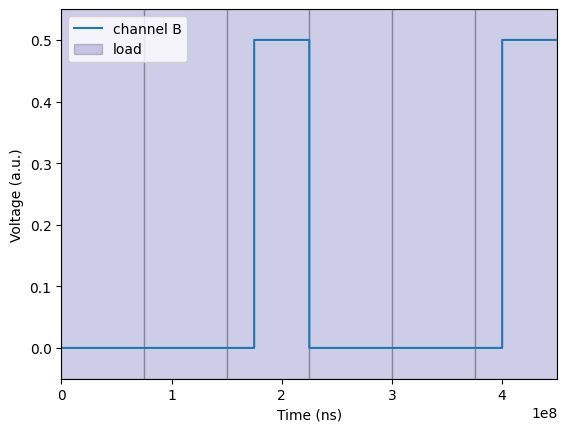

In [3]:
# inspection
from qupulse.pulses.plotting import plot

_ = plot(pattern_FILO, parameters = default_params, 
         plot_measurements=['load'],
         plot_channels=('B'),
         sample_rate = 1e-5)

In [4]:
from qupulse.hardware.setup import HardwareSetup, PlaybackChannel, MarkerChannel
from qupulse.hardware.awgs.zihdawg import HDAWGRepresentation

volatile_prog = pattern_FILO.create_program(parameters=default_params,
                                            volatile='pattern')

# --> adapt hardware setup below
hardware_setup = HardwareSetup()
# awg = HDAWGRepresentation('awg_ip', 'USB')

channel_pairs = []
for pair_name in ('AB', 'CD', 'EF', 'GH'): 
    channel_pair = getattr(awg, 'channel_pair_%s' % pair_name)

    for ch_i, ch_name in enumerate(pair_name):
        playback_name = '{name}_{ch_name}'.format(name='HDAWG', ch_name=ch_name)
        hardware_setup.set_channel(playback_name,
                                    PlaybackChannel(channel_pair, ch_i))
        hardware_setup.set_channel(playback_name + '_MARKER_FRONT', MarkerChannel(channel_pair, 2 * ch_i))
        hardware_setup.set_channel(playback_name + '_MARKER_BACK', MarkerChannel(channel_pair, 2 * ch_i + 1))
awg_channel = awg.channel_pair_AB

volatile_prog.cleanup()

hardware_setup.register_program('test_program', volatile_prog)
hardware_setup.arm_program('test_program')

awg_channel.run_current_program()

hardware_setup.update_parameters('test_program', {'pattern': [1, 1, 0, 0, 1, 1]})
awg_channel.run_current_program()

c:\users\xuera\documents\python\qupulse\qupulse\hardware\awgs\tektronix.py:13: UserWarning: Could not import Tektronix driver backend. If you wish to use it execute qupulse.hardware.awgs.install_requirements('tektronix')
  warnings.warn("Could not import Tektronix driver backend. "


NameError: name 'awg' is not defined

## Make volatiled PT
try to switch over between load_full and load_empty in a duty cycle and wrap it in a RepititionPT such that volatiled repitition count can be used.

In [5]:
# Pulse template for patter FILO
from qupulse.pulses import *
from qupulse.pulses import ParallelConstantChannelPT as ParallelChannelPT
# since when ParallelChannelPT is not a short-cut to ParallelConstantChannelPT?

# Make load and read blocks
read_pls = PointPT([
    ('t_read_0', 'V_read_0'),
    ('t_read_1', 'V_read_1'),
    ('t_read_2', 'V_read_2'),
    ('t_read_3', 'V_read_3'),
    ], tuple('ABCDEFGH'), measurements=[('read', 0, 't_read_3')])

load_full = PointPT([
    ('t_load_0', 'V_load_0'),
    ('t_load_1', 'V_load_1'),
    ('t_load_2', 'V_load_2'),
    ('t_load_3', 'V_load_3'),
    ], tuple('ABCDEFGH'), measurements=[('load', 0, 't_load_3')])

load_none = MappingPT(load_full, parameter_mapping={'V_load_0': 'V_empty_0',
                                                    'V_load_1': 'V_empty_1',
                                                    'V_load_2': 'V_empty_2',
                                                    'V_load_3': 'V_empty_3'})

In [ ]:
duty_cycle = RepetitionPT(load_full, 'n_load_1') @ RepetitionPT(load_none, 'n_load_0')